# Introduction to Optimization

In this worksheet you will implement an optimizer of your choice to minimize a variety of functions.
The intro material is [linked here ](./Phys113_optimization1.pptx).

In [138]:
import numpy as np
import cupy as cp
from scipy.optimize import minimize
from scipy.misc import derivative
import matplotlib.pyplot as plt
from tqdm import tqdm

We will first try to minimize the 2D test functions below. Then we will apply our optimizer to the 40D hanging chain problem.

The Booth function:
$$ f(x_1,x_2) = (x_1 + 2x_2 - 7)^2 + (2x_1 + x_2 - 5)^2$$

The Rosenbrock function:
$$ f(x_1,x_2) = (a - x_1)^2 + b(x_2 - x_1^2)^2$$

The Branin function:
$$ f(x_1,x_2) = a(x_2 - bx_1^2+cx_1-r)^2 + s(1-t)\cos(x_1) + s$$

All these test functions have global minimum function values 
$$ f(x_1^{\star},x_2^{\star}) = 0 $$
The job is to find $(x_1^{\star},x_2^{\star})$.

In [139]:
#Test functions
def branin(x, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)):
    return a*(x[1]-b*x[0]**2+c*x[0]-r)**2 + s*(1-t)*np.cos(x[0]) + s

def booth(x):
    return (x[0]+2*x[1]-7)**2 + (2*x[0]+x[1]-5)**2
    
def rosen(x, a=1, b=5):
    return (a-x[0])**2 + b*(x[1] - x[0]**2)**2



#Gradient functions
def grad_rosen(x, a=1, b=5):
    return np.array([-2*(a-x[0]) - 2*b*(x[1]-x[0]**2)*2*x[0], 2*b*(x[1]-x[0]**2)])

def grad_booth(x):
    return np.array([2*(x[0]+2*x[1]-7) + 4*(2*x[0]+x[1]-5), 
                     4*(x[0]+2*x[1]-7) + 2*(2*x[0]+x[1]-5)])

def grad_branin(x, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)):
    return np.array([2*a*(x[1]-b*x[0]**2+c*x[0]-r)*(-2*b*x[0]+c) - s*(1-t)*np.sin(x[0]), 
                     2*a*(x[1]-b*x[0]**2+c*x[0]-r)])

Here are the test functions plotted as contour plots:

## Rosenbrock

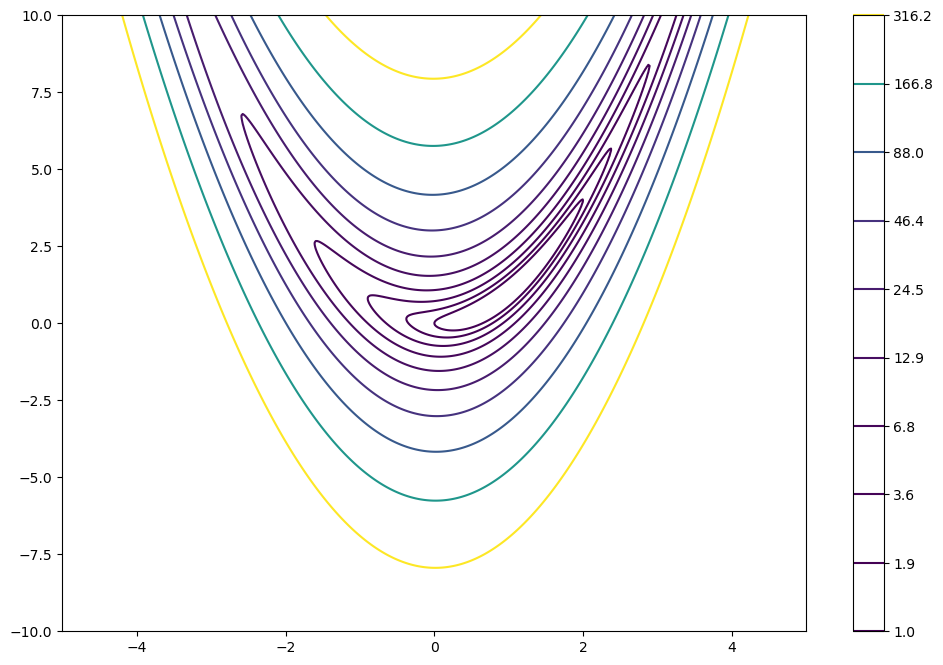

In [140]:
X,Y = np.meshgrid(np.linspace(-5,5,500),np.linspace(-10,10,500))
Z=rosen([X,Y])


fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contour(X, Y, Z,levels=np.logspace(0,2.5,10))
fig.colorbar(CS)

## Booth

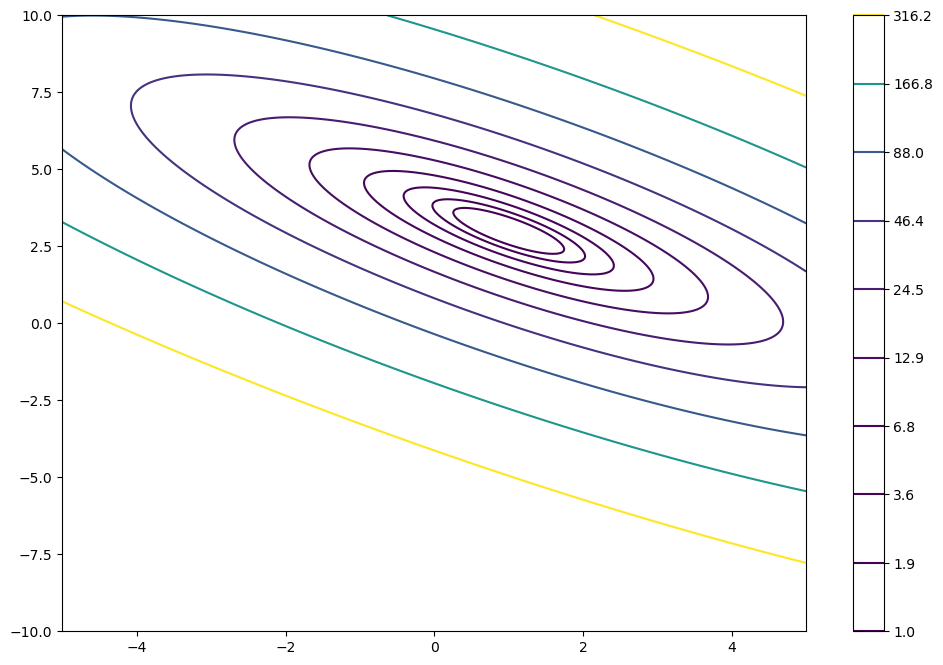

In [141]:
X,Y = np.meshgrid(np.linspace(-5,5,500),np.linspace(-10,10,500))
Z=booth([X,Y])


fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contour(X, Y, Z,levels=np.logspace(0,2.5,10))
fig.colorbar(CS)

## Branin

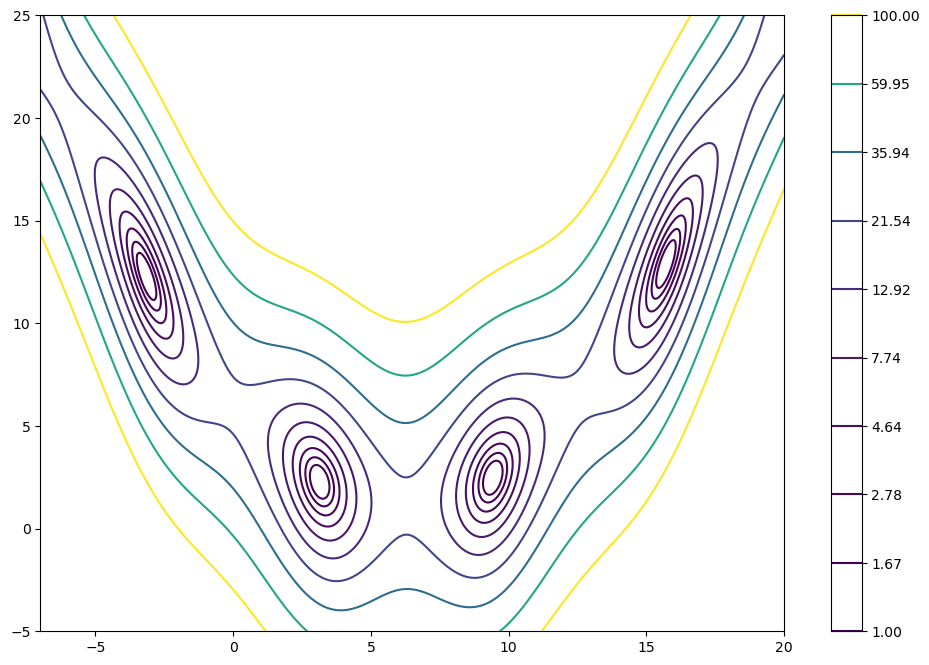

In [142]:
X,Y = np.meshgrid(np.linspace(-7,20,500),np.linspace(-5,25,500))
Z=branin([X,Y])


fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contour(X, Y, Z,levels=np.logspace(0,2,10))
fig.colorbar(CS);

## Optimizer

Implement your descent optimizer of choice here. You can choose any first order or second order method. If you decide to try the more advanced second order methods you will have to write your own Hessian function.

Remember the steps for a descent minimization algorithm:

1. Check whether $\mathbf{x}^{(k)}$ satisfies the termination conditions. If it does, terminate; otherwise proceed to the next step.

2. Determine the descent direction $\mathbf{d}^{(k)}$ using local information such as the gradient or Hessian. Some algorithms assume $\|\mathbf{d}^{(k)}\| = 1$, but others do not.

3. Determine the step size or learning rate $\alpha^{(k)}$. Some algorithms attempt to optimize the step size so that the step maximally decreases $f$.

4. Compute the next design point according to: $ \mathbf{x}^{(k+1)} \leftarrow \mathbf{x}^{(k)} + \alpha^{(k)}\mathbf{d}^{(k)}$

In [157]:
def Optimizer(f, grad_f, x, lr = 1e-3, decay = 1, beta = 0.1, N = 5000, tol = 1e-4, norm = False, noise = 1):
    '''
    Your optimizer will take the function: f, to be minimized, a gradient function: grad_f, 
    that gives the gradient of f at any design point x, and an initial point: x.
    '''
    x_history = []
    n_steps = 0

    v = np.zeros_like(x)
    #insert termination condition, small function change or small gradient
    for _ in tqdm(range(N)):
        if cp.linalg.norm(grad_f(x)) <= tol or n_steps > N:
            break
        #keep record for plot
        x_history.append(x)
        
        #insert step direction
        g = grad_f(x)
        if norm:
            g = g / cp.linalg.norm(g).get()
        g = g + np.random.normal(0, noise, size = g.shape)
        
        alpha = lr * np.exp(-n_steps / N * decay)
        #insert update
        v = beta * np.exp(-n_steps / N * decay) * v - alpha * g
        x = x + v

        #debug
        #print("g:{},x:{},v:{}".format(g,x,v))

        n_steps += 1
    print(n_steps, "total steps")
    return x, f(x), cp.asnumpy(x_history)

In [144]:
x_star, f_star, history = Optimizer(rosen, grad_rosen, np.array([-4,-5]))
print("final x: ", x_star, "final f:", f_star)

100%|██████████| 5000/5000 [00:01<00:00, 3409.84it/s]

5000 total steps
final x:  [0.89310629 0.78841832] final f: 0.011851355222426262


Here I have plotted my solution to the rosenbrock, lets see what yours looks like

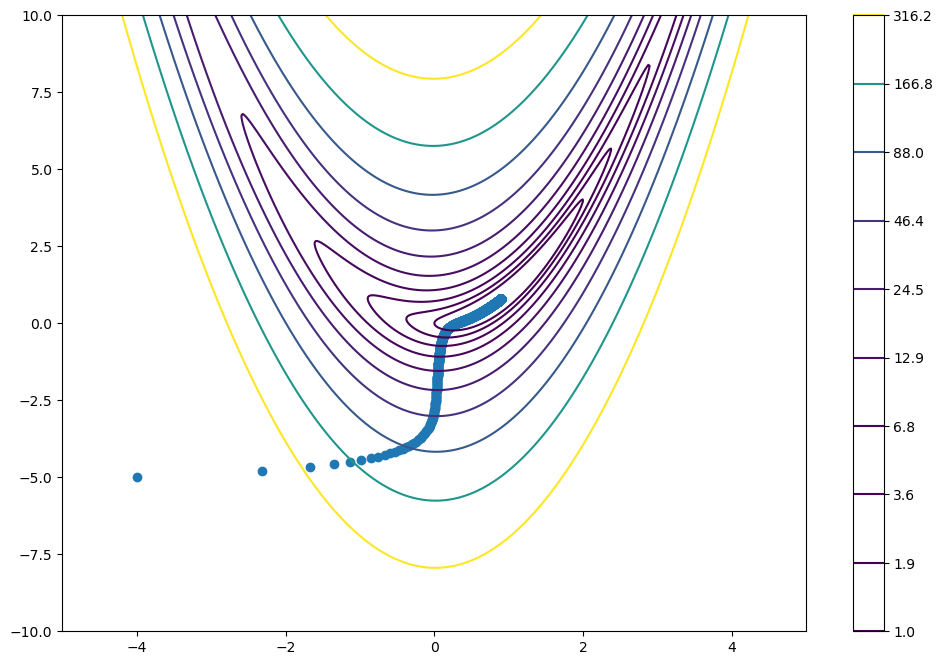

In [145]:
X,Y = np.meshgrid(np.linspace(-5,5,500),np.linspace(-10,10,500))
Z=rosen([X,Y])


fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contour(X, Y, Z,levels=np.logspace(0,2.5,10))
fig.colorbar(CS)


plt.scatter(history[:,0],history[:,1])

Do the same for the booth and branin functions

In [146]:
x_star, f_star, history = Optimizer(booth, grad_booth, np.array([-4,-5]))

100%|██████████| 5000/5000 [00:01<00:00, 2658.03it/s]

5000 total steps


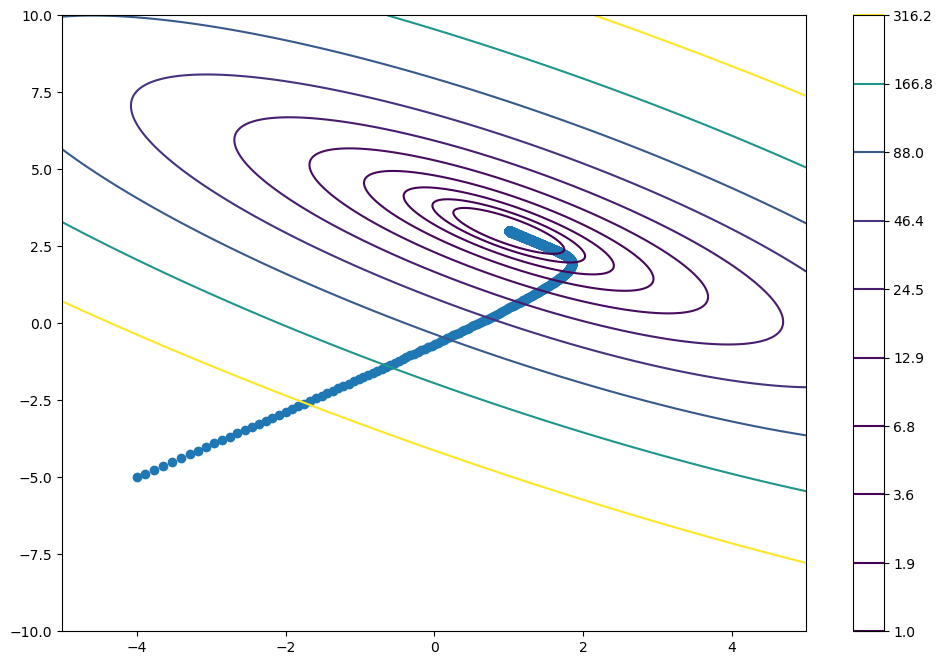

In [147]:
X,Y = np.meshgrid(np.linspace(-5,5,500),np.linspace(-10,10,500))
Z=booth([X,Y])


fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contour(X, Y, Z,levels=np.logspace(0,2.5,10))
fig.colorbar(CS)

plt.scatter(history[:,0],history[:,1])

In [148]:
x_star, f_star, history = Optimizer(branin, grad_branin, np.array([-4,-5]))

100%|██████████| 5000/5000 [00:02<00:00, 2457.34it/s]

5000 total steps


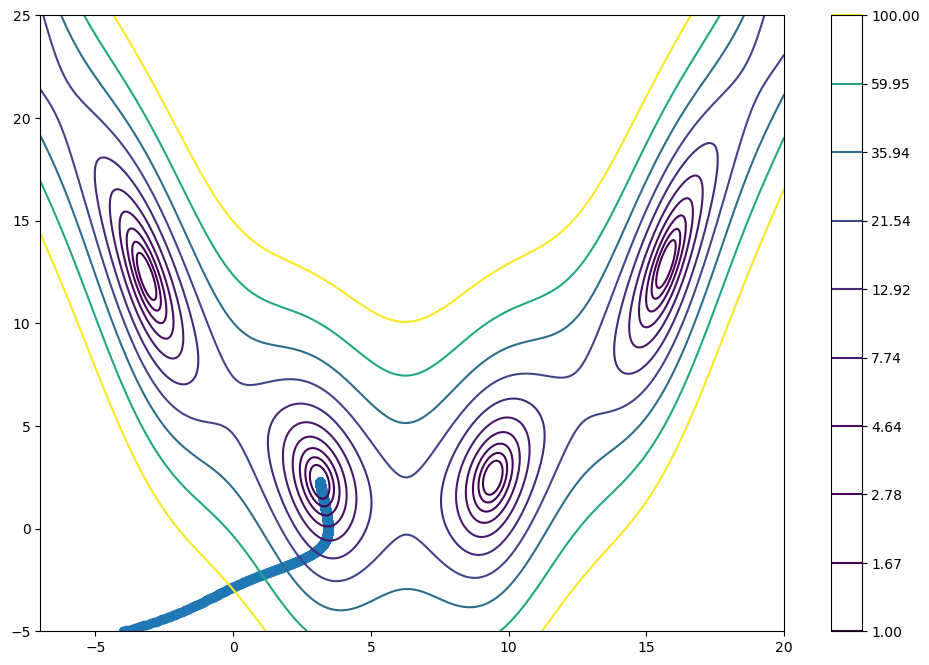

In [149]:
X,Y = np.meshgrid(np.linspace(-7,20,500),np.linspace(-5,25,500))
Z=branin([X,Y])


fig, ax = plt.subplots(figsize=(12,8))
CS = ax.contour(X, Y, Z,levels=np.logspace(0,2,10))
fig.colorbar(CS)

plt.scatter(history[:,0],history[:,1])

Does the minimum reached depend on the initial position for any of these functions? What does that mean in practice?

# Hanging Chain

Here we explore minimizing the potential of a hanging chain of masses and springs (famously a catenary). This is a much higher dimensional problem and so will be more tricky.

The potential we want to minimize is given by: 
$$f(\{x_i,y_i\}_{i=1}^n) = \sum_{i=1}^n9.8y_i + \sum_{i=1}^n\frac{1}{2}k(\sqrt{(x_i - x_{i+1})^2 + (y_i - y_{i+1})^2} - 1)^2 $$

We use the complex step method to estimate the gradient of the potential (the 'force') numerically.

In [171]:
#number of masses in the chain, you're welcome to play with this
n = 20

#Potential energy of hanging chain of masses and springs
def potential(X,n=n,k=1e6,l=1):
    x = X[:n]
    y = X[n:]
    
    left = (0,4)
    right = (n-2,2)
    
    springs = []
    springs.append(0.5*k*(np.sqrt((x[0] - left[0])**2 + (y[0] - left[1])**2) - l)**2)
    springs.append(0.5*k*(np.sqrt((x[-1] - right[0])**2 + (y[-1] - right[1])**2) - l)**2)
    for i in range(n-1):
        springs.append(0.5*k*(np.sqrt((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2) - l)**2)
    return 9.8*np.sum(y) + np.sum(springs)

"""
#Numerical differentiation, complex step method
def num_diff(f, x, h=1e-20):
    grad = []
    for i in range(len(x)):
        vec = np.zeros(len(x)) + 0j
        vec[i] = h*1j
        grad.append(f(x + vec).imag / h)
    return np.array(grad)
"""

def grad_potential(X,n=n,k=1e6,l=1):
    x = X[:n]
    y = X[n:]

    left = (0,4)
    right = (n-2,2)

    grad = np.zeros_like(X)
    grad[n:] += 9.8

    grad[0] = k*(1-l/np.sqrt((x[0] - left[0])**2 + (y[0] - left[1])**2))*(x[0] - left[0])
    grad[0] -= k*(1-l/np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2))*(x[1] - x[0])

    grad[n] = k*(1-l/np.sqrt((x[0] - left[0])**2 + (y[0] - left[1])**2))*(y[0] - left[1])
    grad[n] -= k*(1-l/np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2))*(y[1] - y[0])

    grad[n-1] = k*(1-l/np.sqrt((x[-1] - right[0])**2 + (y[-1] - right[1])**2))*(x[-1] - right[0])
    grad[n-1] -= k*(1-l/np.sqrt((x[-1] - x[-2])**2 + (y[-1] - y[-2])**2))*(x[-2] - x[-1])

    grad[-1] = k*(1-l/np.sqrt((x[-1] - right[0])**2 + (y[-1] - right[1])**2))*(y[-1] - right[1])
    grad[-1] -= k*(1-l/np.sqrt((x[-1] - x[-2])**2 + (y[-1] - y[-2])**2))*(y[-2] - y[-1])

    for i in range(1,n-1):
        grad[i] = k*(1-l/np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2))*(x[i] - x[i-1])
        grad[i] -= k*(1-l/np.sqrt((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2))*(x[i+1] - x[i])

        grad[n+i] = k*(1-l/np.sqrt((x[i] - x[i-1])**2 + (y[i] - y[i-1])**2))*(y[i] - y[i-1])
        grad[n+i] -= k*(1-l/np.sqrt((x[i+1] - x[i])**2 + (y[i+1] - y[i])**2))*(y[i+1] - y[i])
    
    return grad

Let's see how close you can get to the true (minimum) solution

In [172]:
#initial x0 a random assembly of the masses:
x0 = np.concatenate([np.random.uniform(0,n-2,size=n),np.random.uniform(0,4,size=n)])

#You may need to improve your descent Optimizer to converge to the correct
#solution in a reasonable number of steps, good luck!
x_star, f_star, history = Optimizer(potential, grad_potential, x0, decay = 3, lr = 0.05, noise = 1, beta = 0.2, N = 25000, norm = True, tol = 1e-7)
print(f_star)

100%|██████████| 25000/25000 [00:29<00:00, 856.41it/s]

25000 total steps
753.1811247663456


In [173]:
#Here is the scipy function that does it all for you.
res = minimize(potential, x0)
print(res)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -23.1528609045036
        x: [ 6.346e-01  1.307e+00 ...  6.859e-01  1.319e+00]
      nit: 346
      jac: [ 1.645e-01  4.197e-01 ...  2.189e-01 -2.827e-01]
 hess_inv: [[ 1.552e-03  1.746e-03 ...  3.090e-04 -3.448e-04]
            [ 1.746e-03  2.068e-03 ...  3.721e-04 -4.263e-04]
            ...
            [ 3.090e-04  3.721e-04 ...  3.721e-04 -4.152e-05]
            [-3.448e-04 -4.263e-04 ... -4.152e-05  1.039e-04]]
     nfev: 18585
     njev: 453


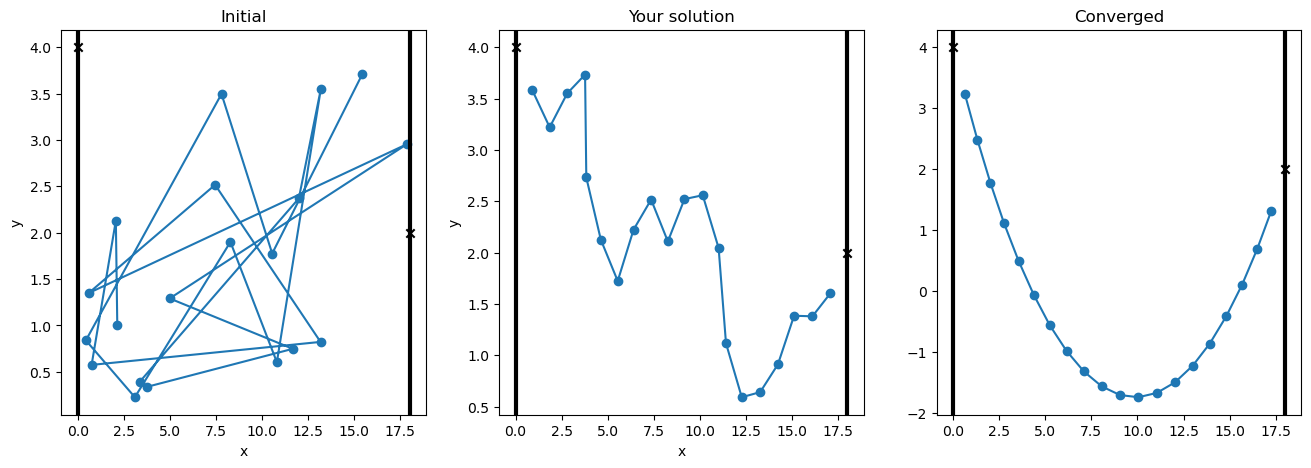

In [174]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(16,5),ncols=3)

ax1.scatter(x0[:n],x0[n:])
ax1.plot(x0[:n],x0[n:])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Initial')
ax1.axvline(0,color='k',linewidth=3)
ax1.axvline(n-2, color='k',linewidth=3)
ax1.scatter([0,n-2],[4,2],color='k',marker='x')



ax2.scatter(x_star[:n],x_star[n:])
ax2.plot(x_star[:n],x_star[n:])
ax2.set_title('Your solution')

ax2.scatter([0,n-2],[4,2],color='k',marker='x')
ax2.axvline(0,color='k',linewidth=3)
ax2.axvline(n-2, color='k',linewidth=3)
ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax3.scatter(res['x'][:n],res['x'][n:])
ax3.plot(res['x'][:n],res['x'][n:])
ax3.set_title('Converged')
ax3.axvline(0,color='k',linewidth=3)
ax3.axvline(n-2, color='k',linewidth=3)
ax3.scatter([0,n-2],[4,2],color='k',marker='x')


In [175]:
import matplotlib.animation as animation
from IPython.display import HTML

In [176]:
def HarmMovie(history):
    fig, ax = plt.subplots(figsize=(6,6))
    plt.close()

    def animate(i):
        ax.cla()
        ax.set_xlim((0, 18))
        ax.set_ylim((-2, 4))
        return ax.plot(history[i][:n],history[i][n:], 'x-', lw=3)

    return animation.FuncAnimation(fig, animate, frames=range(0, len(history), 500), blit=True)

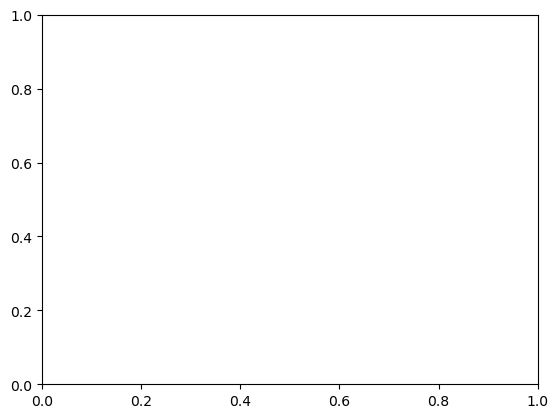

In [177]:
fig, ax = plt.subplots()
anim = HarmMovie(history)
HTML(anim.to_jshtml())